In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import folium
from folium import plugins
import json

import plotly
import cufflinks as cf
import plotly.express as px

# 오프라인 모드에서도 인터렉티브한 그래픽을 가능하도록 함
from plotly.offline import download_plotlyjs,init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

# 다중 그래프 그리기
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# PART I. 최종 DataFrame 생성

브랜드끼리의 상관관계, 버거지수와 인구/인구밀도/경제지표의 상관관계를 분석하기 위해서 최종적으로 원하는 DataFrame은 아래와 같이 생겼다.

|index|시+구,군|맥도날드|버거킹|KFC|롯데리아|버거지수|인구/인구밀도/경제지표|
|---|---|---|---|---|---|---|---|
|0|서울특별시 강남구| 11|7 |11 | 20|1.45 | 44865 |
|...|...|...|...|...|...|...|...|


In [35]:
# 데이터 불러오기
burger_df = pd.read_csv("./burger_df.csv")
print(burger_df.shape)
burger_df

(2306, 6)


,지점명,주소,브랜드,주소1,주소2,주소3
0,선릉역점,서울특별시 강남구 선릉로 429,버거킹,서울특별시,강남구,선릉로 429
1,대치역점,서울특별시 강남구 남부순환로 2936,버거킹,서울특별시,강남구,남부순환로 2936
2,차병원사거리점,서울특별시 강남구 봉은사로 179,버거킹,서울특별시,강남구,봉은사로 179
3,강남도곡점,서울특별시 강남구 논현로 172 (도곡동 410-10) 1층,버거킹,서울특별시,강남구,논현로 172 (도곡동 410-10) 1층
4,청담점,서울특별시 강남구 선릉로 812,버거킹,서울특별시,강남구,선릉로 812
...,...,...,...,...,...,...
2301,여의도선착장,서울 영등포구 여의동로 290,롯데리아,서울특별시,영등포구,여의동로 290
2302,청주하나로,충북 청주시 상당구 무농정로 32 청주하나로클럽內,롯데리아,충청북도,청주시,상당구 무농정로 32 청주하나로클럽內
2303,전주효자서부,전북 전주시 완산구 호암로 65,롯데리아,전라북도,전주시,완산구 호암로 65
2304,시흥정왕역,경기 시흥시 마유로418번 길10,롯데리아,경기도,시흥시,마유로418번 길10


In [36]:
# 데이터 결측치 확인
burger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지점명     2306 non-null   object
 1   주소      2306 non-null   object
 2   브랜드     2306 non-null   object
 3   주소1     2306 non-null   object
 4   주소2     2306 non-null   object
 5   주소3     2306 non-null   object
dtypes: object(6)
memory usage: 108.2+ KB


In [37]:
# 브랜드 종류 확인
burger_df["브랜드"].unique()

array(['버거킹', 'KFC', '맥도날드', '롯데리아'], dtype=object)

In [38]:
# 주소1(시,도) 분류 확인
burger_df["주소1"].unique()

array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도',
       '제주특별자치도', '세종특별자치시'], dtype=object)

In [39]:
# 주소1+2 컬럼 만들기
burger_df["주소1+2"] = burger_df["주소1"]+" "+burger_df["주소2"]
burger_df

,지점명,주소,브랜드,주소1,주소2,주소3,주소1+2
0,선릉역점,서울특별시 강남구 선릉로 429,버거킹,서울특별시,강남구,선릉로 429,서울특별시 강남구
1,대치역점,서울특별시 강남구 남부순환로 2936,버거킹,서울특별시,강남구,남부순환로 2936,서울특별시 강남구
2,차병원사거리점,서울특별시 강남구 봉은사로 179,버거킹,서울특별시,강남구,봉은사로 179,서울특별시 강남구
3,강남도곡점,서울특별시 강남구 논현로 172 (도곡동 410-10) 1층,버거킹,서울특별시,강남구,논현로 172 (도곡동 410-10) 1층,서울특별시 강남구
4,청담점,서울특별시 강남구 선릉로 812,버거킹,서울특별시,강남구,선릉로 812,서울특별시 강남구
...,...,...,...,...,...,...,...
2301,여의도선착장,서울 영등포구 여의동로 290,롯데리아,서울특별시,영등포구,여의동로 290,서울특별시 영등포구
2302,청주하나로,충북 청주시 상당구 무농정로 32 청주하나로클럽內,롯데리아,충청북도,청주시,상당구 무농정로 32 청주하나로클럽內,충청북도 청주시
2303,전주효자서부,전북 전주시 완산구 호암로 65,롯데리아,전라북도,전주시,완산구 호암로 65,전라북도 전주시
2304,시흥정왕역,경기 시흥시 마유로418번 길10,롯데리아,경기도,시흥시,마유로418번 길10,경기도 시흥시


In [40]:
# 브랜드별로 데이터 묶기
bking_grp = burger_df[burger_df["브랜드"]=="버거킹"]
kfc_grp = burger_df[burger_df["브랜드"]=="KFC"]
mc_grp = burger_df[burger_df["브랜드"]=="맥도날드"]
lotte_grp = burger_df[burger_df["브랜드"]=="롯데리아"]

bking_grp.shape, kfc_grp.shape, mc_grp.shape, lotte_grp.shape # 갯수 확인

((410, 7), (187, 7), (405, 7), (1304, 7))

In [41]:
# 시구군별로 매장수 세기
bking_cnt =  bking_grp.groupby("주소1+2").count()["지점명"]
kfc_cnt = kfc_grp.groupby("주소1+2").count()["지점명"]
mc_cnt = mc_grp.groupby("주소1+2").count()["지점명"]
lotte_cnt = lotte_grp.groupby("주소1+2").count()["지점명"]

bking_cnt.shape, kfc_cnt.shape, mc_cnt.shape, lotte_cnt.shape

((129,), (90,), (132,), (238,))

In [42]:
# column 이름을 Series.name 에 저장
bking_cnt.name = "버거킹"
kfc_cnt.name = "KFC"
mc_cnt.name = "맥도날드"
lotte_cnt.name = "롯데리아"

In [43]:
# Series 데이터 확인
print(bking_cnt)
print()
print(kfc_cnt)
print()
print(mc_cnt)
print()
print(lotte_cnt)
print()

주소1+2
강원도 강릉시     1
강원도 속초시     1
강원도 원주시     3
강원도 춘천시     2
강원도 홍천군     2
           ..
충청남도 홍성군    1
충청북도 음성군    1
충청북도 진천군    1
충청북도 청주시    7
충청북도 충주시    1
Name: 버거킹, Length: 129, dtype: int64

주소1+2
강원도 원주시         1
강원도 춘천시         2
경기도 고양시         5
경기도 광명시         2
경기도 구리시         1
               ..
제주특별자치도 서귀포시    1
충청남도 당진시        1
충청남도 아산시        1
충청남도 천안시        3
충청북도 청주시        2
Name: KFC, Length: 90, dtype: int64

주소1+2
강원도 강릉시     1
강원도 동해시     1
강원도 속초시     1
강원도 원주시     2
강원도 춘천시     2
           ..
충청남도 천안시    4
충청남도 홍성군    1
충청북도 제천시    1
충청북도 청주시    6
충청북도 충주시    1
Name: 맥도날드, Length: 132, dtype: int64

주소1+2
강원도 강릉시      6
강원도 고성군      1
강원도 동해시      3
강원도 삼척시      1
강원도 속초시      3
            ..
충청북도 증평군     1
충청북도 진천군     2
충청북도 청원군     4
충청북도 청주시    27
충청북도 충주시     8
Name: 롯데리아, Length: 238, dtype: int64



In [44]:
# Series 합치기
nstore_df = pd.concat([bking_cnt, kfc_cnt, mc_cnt, lotte_cnt], axis=1) # 시리즈 합치기, 합치면서 dtypes=float으로 변하는 것 같다
nstore_df = nstore_df.fillna(0) # 결측치 0으로 채우기 
nstore_df = nstore_df.astype("int") # 자료형 타입 int로 바꾸기

print(nstore_df.info())
nstore_df

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 강원도 강릉시 to 충청북도 청원군
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   버거킹     240 non-null    int32
 1   KFC     240 non-null    int32
 2   맥도날드    240 non-null    int32
 3   롯데리아    240 non-null    int32
dtypes: int32(4)
memory usage: 5.6+ KB
None


,버거킹,KFC,맥도날드,롯데리아
강원도 강릉시,1,0,1,6
강원도 속초시,1,0,1,3
강원도 원주시,3,1,2,15
강원도 춘천시,2,2,2,7
강원도 홍천군,2,0,0,2
...,...,...,...,...
충청북도 보은군,0,0,0,1
충청북도 영동군,0,0,0,1
충청북도 옥천군,0,0,0,2
충청북도 증평군,0,0,0,1


In [45]:
# 시군구 중복 확인
len(nstore_df.index), len(set(nstore_df.index)) 

(240, 240)

In [46]:
# 버거지수 만들기 전 롯데리아 매장이 없는 지역 확인 → 0으로 나누면 inf이 된다! nan으로 처리
nstore_df[nstore_df["롯데리아"]==0]

,버거킹,KFC,맥도날드,롯데리아
인천광역시 미추홀구,3,1,1,0
세종특별자치시 금송로,0,1,0,0


In [47]:
# 버거지수 컬럼 만들기
nstore_df["BKM"]=nstore_df["버거킹"]+nstore_df["KFC"]+nstore_df["맥도날드"]
nstore_df["버거지수"] = nstore_df["BKM"]/nstore_df["롯데리아"] 

# 이상치 처리
nstore_df.loc["인천광역시 미추홀구","버거지수"]= None
nstore_df.loc["세종특별자치시 금송로","버거지수"] = None
nstore_df

,버거킹,KFC,맥도날드,롯데리아,BKM,버거지수
강원도 강릉시,1,0,1,6,2,0.333333
강원도 속초시,1,0,1,3,2,0.666667
강원도 원주시,3,1,2,15,6,0.400000
강원도 춘천시,2,2,2,7,6,0.857143
강원도 홍천군,2,0,0,2,2,1.000000
...,...,...,...,...,...,...
충청북도 보은군,0,0,0,1,0,0.000000
충청북도 영동군,0,0,0,1,0,0.000000
충청북도 옥천군,0,0,0,2,0,0.000000
충청북도 증평군,0,0,0,1,0,0.000000


In [48]:
# 인덱스를 주소1(시,도), 주소2(시,군,구)로 나누기, 인덱싱 재설정은 나중에 한다
nstore_df["주소"] = nstore_df.index
nstore_df[["주소1","주소2"]] = nstore_df["주소"].str.strip().str.split().tolist()
nstore_df

,버거킹,KFC,맥도날드,롯데리아,BKM,버거지수,주소,주소1,주소2
강원도 강릉시,1,0,1,6,2,0.333333,강원도 강릉시,강원도,강릉시
강원도 속초시,1,0,1,3,2,0.666667,강원도 속초시,강원도,속초시
강원도 원주시,3,1,2,15,6,0.400000,강원도 원주시,강원도,원주시
강원도 춘천시,2,2,2,7,6,0.857143,강원도 춘천시,강원도,춘천시
강원도 홍천군,2,0,0,2,2,1.000000,강원도 홍천군,강원도,홍천군
...,...,...,...,...,...,...,...,...,...
충청북도 보은군,0,0,0,1,0,0.000000,충청북도 보은군,충청북도,보은군
충청북도 영동군,0,0,0,1,0,0.000000,충청북도 영동군,충청북도,영동군
충청북도 옥천군,0,0,0,2,0,0.000000,충청북도 옥천군,충청북도,옥천군
충청북도 증평군,0,0,0,1,0,0.000000,충청북도 증평군,충청북도,증평군


#### 주소2(시,군,구) 중복 확인
- 이 후에 주소2를 기준으로 인구나 인구밀도 정보를 넣어도 되는지 알기 위해서 중복을 확인한다.
- 결과 : 중복있음. 주소2를 기준으로 인구나 인구밀도 정보를 넣으면 안된다. 
- 대신, 인덱스 값은 중복이 없으니 기준으로 사용할 것이다. reset_index를 통해 숫자형 인덱스를 지정하고 기존의 값을 새로운 컬럼에 저장한다. 

#### cf. 중복 제거 방식 2가지
1. set 사용하여 길이 비교
2. pandas.drop_duplicates() 메서드 사용

In [49]:
# 주소2(시,군,구) 중복 확인
print(len(nstore_df['주소2']))
print(len(set(nstore_df["주소2"]))) # 중복 제거 - 1. set 사용
print(len(nstore_df["주소2"].drop_duplicates())) # 중복 제거 - 2. pandas.drop_duplicates() 사용

nstore_df['주소2'].value_counts().head(10) # 어느 도/시에서 겹치는거지? 아래의 셀에서 확인

240
218
218


중구     6
서구     5
남구     5
동구     5
북구     4
강서구    2
고성군    2
원주시    1
수성구    1
문경시    1
Name: 주소2, dtype: int64

In [50]:
# 주소2(시,군,구) 이름이 겹치는 주소1(시,도) 
list_duplicates = list(nstore_df['주소2'].value_counts().head(6).index)
list_duplicates

for one in list_duplicates :
    print(nstore_df[nstore_df["주소2"]==one]["주소1"], "\n")

대구광역시 중구    대구광역시
대전광역시 중구    대전광역시
서울특별시 중구    서울특별시
울산광역시 중구    울산광역시
인천광역시 중구    인천광역시
부산광역시 중구    부산광역시
Name: 주소1, dtype: object 

광주광역시 서구    광주광역시
대구광역시 서구    대구광역시
대전광역시 서구    대전광역시
인천광역시 서구    인천광역시
부산광역시 서구    부산광역시
Name: 주소1, dtype: object 

광주광역시 남구    광주광역시
대구광역시 남구    대구광역시
부산광역시 남구    부산광역시
울산광역시 남구    울산광역시
인천광역시 남구    인천광역시
Name: 주소1, dtype: object 

광주광역시 동구    광주광역시
대구광역시 동구    대구광역시
대전광역시 동구    대전광역시
울산광역시 동구    울산광역시
부산광역시 동구    부산광역시
Name: 주소1, dtype: object 

광주광역시 북구    광주광역시
대구광역시 북구    대구광역시
부산광역시 북구    부산광역시
울산광역시 북구    울산광역시
Name: 주소1, dtype: object 

서울특별시 강서구    서울특별시
부산광역시 강서구    부산광역시
Name: 주소1, dtype: object 



#### cf. 인덱싱 재설정 `reset_index(drop=False, inplace=False)`
- drop : 기존의 인덱스 값을 삭제할 것인가?
    - False(default) : 삭제하지 않고 새로운 컬럼에 저장
    - True : 삭제
- inplace : 기존의 데이터프레임에 저장할 것인가?
    - False(default) : 기존의 데이터프레임에는 저장하지 않고 출력만 
    - True : 기존의 데이터프레임에 저장

In [51]:
# 인덱싱 재설정
nstore_df.reset_index(drop=True, inplace=True) 
nstore_df

,버거킹,KFC,맥도날드,롯데리아,BKM,버거지수,주소,주소1,주소2
0,1,0,1,6,2,0.333333,강원도 강릉시,강원도,강릉시
1,1,0,1,3,2,0.666667,강원도 속초시,강원도,속초시
2,3,1,2,15,6,0.400000,강원도 원주시,강원도,원주시
3,2,2,2,7,6,0.857143,강원도 춘천시,강원도,춘천시
4,2,0,0,2,2,1.000000,강원도 홍천군,강원도,홍천군
...,...,...,...,...,...,...,...,...,...
235,0,0,0,1,0,0.000000,충청북도 보은군,충청북도,보은군
236,0,0,0,1,0,0.000000,충청북도 영동군,충청북도,영동군
237,0,0,0,2,0,0.000000,충청북도 옥천군,충청북도,옥천군
238,0,0,0,1,0,0.000000,충청북도 증평군,충청북도,증평군


# PART II. 버거지수와 경제 지표의 상관관계
## 경제 지표 가져오기
- 출처 : [통계청](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1C86&conn_path=I2)  
- 파일명 : *시도별_1인당_지역내총생산\__지역총소득\__개인소득_20210702225439.csv* 
- 설명 : (2019년 기준) 전국 16개 시도별 `1인당 지역내총생산`, `1인당 지역총소득`,`1인당 개인소득`,`1인당 민간소비`

In [52]:
eco_index = pd.read_csv("시도별_1인당_지역내총생산__지역총소득__개인소득_20210702225439.csv", encoding='cp949', skiprows=1)
eco_index

,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비
0,전국,37208,37530,20400,17962
1,서울특별시,44865,49121,23440,21891
2,부산광역시,27409,29388,19680,18030
3,대구광역시,23744,27798,19210,17850
4,인천광역시,30425,32571,19332,16451
5,광주광역시,27548,30964,20532,18231
6,대전광역시,28364,31548,20498,18025
7,울산광역시,65352,54969,22550,18482
8,세종특별자치시,35826,36983,19789,16762
9,경기도,36133,38466,20482,17399


In [53]:
# 행정구역 이름이 같은지 확인
print(set(eco_index["시도별"][1:]) == set(nstore_df["주소1"].unique()))

True


### 두가지 방식
경제지표가 __시군구 단위__가 아니라 __시도 단위__이기 때문에 분석 방법에 <U>두가지</U>가 있다.  
#### 1. `nstore_df`에 `eco_index`를 join하는 방식
- 어떤 구/군인가에 상관없이 동일한 시/도에 포함되면 동일한 경제지표를 가지게 된다.  
- 방식 2.보다는 구/군에 따른 데이터 수가 많기 때문에 산점도를 그렸을 때 더 세부적인 버거지수 비교가 가능하다.
- 시의 경제 지표가 그에 포함된 구의 경제지표를 대표하기엔 다소 무리가 있다. 각 시/도 안에서도 경제적인 수준의 편차가 존재하기 때문에.  

#### 2. `eco_index`에 `nstore_df`를 join하는 방식
- 해당 시/도당 하나의 버거지수
- 버거지수-경제지표 산점도에 데이터 수가 줄어든다.
- 논리적으로는 이 방식이 더 맞아보인다.

## 방식 1.  nstore_df에 eco_index를 join한다.

In [54]:
df_1 = pd.merge(nstore_df, eco_index, left_on="주소1", right_on='시도별', how='left')
df_1

,버거킹,KFC,맥도날드,롯데리아,BKM,버거지수,주소,주소1,주소2,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비
0,1,0,1,6,2,0.333333,강원도 강릉시,강원도,강릉시,강원도,32061,29392,18997,16811
1,1,0,1,3,2,0.666667,강원도 속초시,강원도,속초시,강원도,32061,29392,18997,16811
2,3,1,2,15,6,0.400000,강원도 원주시,강원도,원주시,강원도,32061,29392,18997,16811
3,2,2,2,7,6,0.857143,강원도 춘천시,강원도,춘천시,강원도,32061,29392,18997,16811
4,2,0,0,2,2,1.000000,강원도 홍천군,강원도,홍천군,강원도,32061,29392,18997,16811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0,0,0,1,0,0.000000,충청북도 보은군,충청북도,보은군,충청북도,42653,34484,18823,15802
236,0,0,0,1,0,0.000000,충청북도 영동군,충청북도,영동군,충청북도,42653,34484,18823,15802
237,0,0,0,2,0,0.000000,충청북도 옥천군,충청북도,옥천군,충청북도,42653,34484,18823,15802
238,0,0,0,1,0,0.000000,충청북도 증평군,충청북도,증평군,충청북도,42653,34484,18823,15802


In [55]:
import plotly.express as px

px.scatter(df_1, x='버거지수', y='1인당 지역내총생산', trendline='ols')

[comments] 버거지수가 달라도 동일한 시,도 안에 있으면 동일한 경제 지표로 표시되기 때문에 의미있는 결과를 얻을 수 없었다.  
방식1은 실패!

## 방식 2. `eco_index`에 `nstore_df`를 join하는 방식

In [23]:
new_nstore_df = nstore_df.groupby("주소1").sum()[["버거킹","KFC","맥도날드","롯데리아"]] 
new_nstore_df # 롯데리아가 없는 시,도가 있는지 직접 확인

,버거킹,KFC,맥도날드,롯데리아
주소1,,,,
강원도,9,3,7,54
경기도,100,50,96,317
경상남도,24,4,29,87
경상북도,25,4,15,68
광주광역시,15,3,10,42
대구광역시,20,10,25,66
대전광역시,14,5,13,51
부산광역시,20,9,41,82
서울특별시,111,73,96,181


In [56]:
new_nstore_df["BKM"]= new_nstore_df["버거킹"]+new_nstore_df["KFC"]+new_nstore_df["맥도날드"]
new_nstore_df["버거지수"] = new_nstore_df["BKM"]/new_nstore_df["롯데리아"]
new_nstore_df

,버거킹,KFC,맥도날드,롯데리아,버거지수,BKM
주소1,,,,,,
강원도,9,3,7,54,0.351852,19
경기도,100,50,96,317,0.776025,246
경상남도,24,4,29,87,0.655172,57
경상북도,25,4,15,68,0.647059,44
광주광역시,15,3,10,42,0.666667,28
대구광역시,20,10,25,66,0.833333,55
대전광역시,14,5,13,51,0.627451,32
부산광역시,20,9,41,82,0.853659,70
서울특별시,111,73,96,181,1.546961,280


In [57]:
df_2 = pd.merge(new_nstore_df, eco_index, left_on=new_nstore_df.index, right_on='시도별', how='left')
df_2

,버거킹,KFC,맥도날드,롯데리아,버거지수,BKM,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비
0,9,3,7,54,0.351852,19,강원도,32061,29392,18997,16811
1,100,50,96,317,0.776025,246,경기도,36133,38466,20482,17399
2,24,4,29,87,0.655172,57,경상남도,33690,32140,18939,16426
3,25,4,15,68,0.647059,44,경상북도,40272,34873,18611,16217
4,15,3,10,42,0.666667,28,광주광역시,27548,30964,20532,18231
5,20,10,25,66,0.833333,55,대구광역시,23744,27798,19210,17850
6,14,5,13,51,0.627451,32,대전광역시,28364,31548,20498,18025
7,20,9,41,82,0.853659,70,부산광역시,27409,29388,19680,18030
8,111,73,96,181,1.546961,280,서울특별시,44865,49121,23440,21891
9,0,1,0,10,0.100000,1,세종특별자치시,35826,36983,19789,16762


In [58]:
fig = make_subplots(rows=2, cols=2)
index1 = go.Scatter(x=df_2['버거지수'], y=df_2['1인당 민간소비'],mode='markers')
index2 = go.Scatter(x=df_2['버거지수'], y=df_2['1인당 지역총소득'], mode='markers')
index3 = go.Scatter(x=df_2['버거지수'], y=df_2['1인당 개인소득'], mode='markers')
index4 = go.Scatter(x=df_2['버거지수'], y=df_2['1인당 민간소비'], mode='markers')

fig.add_trace(index1, row=1, col=1)
fig.add_trace(index2, row=1, col=2)
fig.add_trace(index3, row=2, col=1)
fig.add_trace(index4, row=2, col=2)

layout = {
    "yaxis": {"title": "1인당 민간소비"},
    "yaxis2": {"title": "1인당 지역총소득"},
    "xaxis3": {"title": "버거지수"},
    "yaxis3": {"title":"1인당 개인소득"},
    "xaxis4" : {"title":"버거지수"},
    "yaxis4": {"title": "1인당 민간소비"}
}

fig.update_layout(layout)

In [59]:
# '1인당 지역내총생산', '1인당 지역총소득','1인당 개인소득', '1인당 민간소비'
px.scatter(df_2, x='버거지수', y='1인당 지역내총생산', trendline='ols', hover_name='시도별') 

In [60]:
# '1인당 지역내총생산', '1인당 지역총소득','1인당 개인소득', '1인당 민간소비'
px.scatter(df_2, x='버거지수', y='1인당 지역총소득', trendline='ols', hover_name='시도별') 

In [61]:
# '1인당 지역내총생산', '1인당 지역총소득','1인당 개인소득', '1인당 민간소비'
px.scatter(df_2, x='버거지수', y='1인당 개인소득', trendline='ols', hover_name='시도별') 

In [62]:
# '1인당 지역내총생산', '1인당 지역총소득','1인당 개인소득', '1인당 민간소비'
px.scatter(df_2, x='버거지수', y='1인당 민간소비', trendline='ols', hover_name='시도별') 

In [63]:
from matplotlib import font_manager, rc
import platform

path = "C:/Windows/Fonts/malgun.ttf" 
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name) 
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic') 
else:
    print("Unknown System") 

# matplotlib.rcParams['axes.unicode_minus'] = False

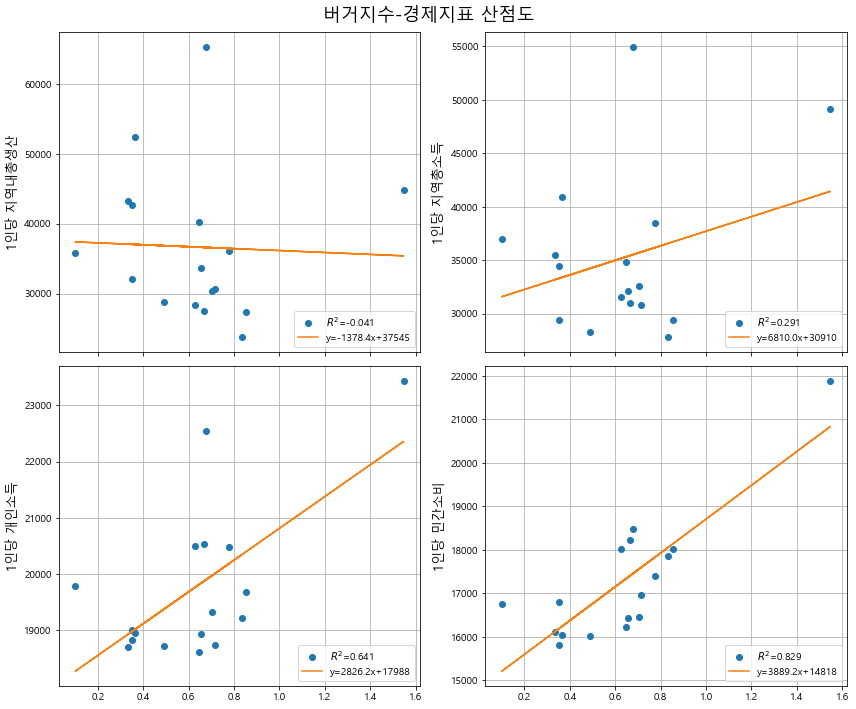

In [64]:
x = df_2["버거지수"]
col_label = ['1인당 지역내총생산', '1인당 지역총소득','1인당 개인소득', '1인당 민간소비']

fig, axes = plt.subplots(2,2, figsize=(12,10), sharex=True)

ncol = 0
for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        y_label = col_label[ncol]
        y = np.array(df_2[y_label].tolist())
        
        z = np.polyfit(x,y,1)
        f = np.poly1d(z)
        
        R = np.corrcoef(x, y)[0][1]
        
        ax.plot(x, y,'o', label=r'$R^{2}$'+'={:.3f}'.format(R))
        ax.plot(x, f(x), label='y={:.1f}x+{:.0f}'.format(z[0],z[1]))
        ax.set_ylabel(y_label, fontsize=13)
        ax.grid(True)
        ax.legend(loc=4)

        ncol += 1

plt.suptitle("버거지수-경제지표 산점도", fontsize=18)
plt.tight_layout()

[comments] 
- plotly, plotly.express 못해먹겠다... plotly.graph_objects는 trendline이 안그려지고 plotly.express는 subplots이 안된다.. 그냥 matplotlib으로 해야겠다
- 경제 지표별로 회귀선 차이가 꽤 난다. 경제지표가 무엇을 의미하는지를 알아야지 해석이 가능할 것 같다. 최대한 많은 시각화 자료를 만들고 해석은 조원들과 나누면서 결정하자


# PART III. 버거지수와 인구수/인구밀도의 상관관계

## 시도별 인구수/인구밀도 데이터 가져오기
- 출처 : 시도별 인구수/인구밀도 [통계청](https://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=1007&stts_cd=100701&freq=Y)
- 파일명: *stat_100701.xls*
- 설명 : (2020년 기준) 전국 16개 시도별 `인구`[천명], `인구밀도`[명/km^2]

### 인구수/인구밀도 데이터 전처리

In [65]:
pop_df_all = pd.read_excel("stat_100701.xls",skiprows=3)
pop_df = pop_df_all[1:-5] # 불필요한 행 제거
pop_df = pop_df[["Unnamed: 0", "인구.1","인구밀도.1"]] # 불필요한 열 제거
pop_df = pop_df.rename(columns={"Unnamed: 0": "행정구역", "인구.1":"인구","인구밀도.1":"인구밀도"}) # 컬럼명 수정
# 행정구역 이름 동일화
pop_df = pop_df.replace({'서울':'서울특별시',
                        '부산':'부산광역시',
                        '대구':'대구광역시',
                        '인천':'인천광역시',
                        '광주':'광주광역시',
                        '대전':'대전광역시',
                        '울산':'울산광역시',
                        '세종':'세종특별자치시',
                        '경기':'경기도',
                        '강원':'강원도',
                        '충북':'충청북도',
                        '충남':'충청남도',
                        '전북':'전라북도',
                        '전남':'전라남도',
                        '경북':'경상북도',
                        '경남':'경상남도',
                        '제주':'제주특별자치도'})

pop_df
# pop_df.info()

,행정구역,인구,인구밀도
1,서울특별시,"9,602","15,865"
2,부산광역시,"3,344","4,342"
3,대구광역시,"2,419","2,738"
4,인천광역시,"2,951","2,770"
5,광주광역시,"1,488","2,969"
6,대전광역시,"1,500","2,780"
7,울산광역시,"1,140","1,073"
8,세종특별자치시,349,750
9,경기도,"13,405","1,315"
10,강원도,"1,515",90


In [66]:
# new_nstore_df 
df_2

,버거킹,KFC,맥도날드,롯데리아,버거지수,BKM,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비
0,9,3,7,54,0.351852,19,강원도,32061,29392,18997,16811
1,100,50,96,317,0.776025,246,경기도,36133,38466,20482,17399
2,24,4,29,87,0.655172,57,경상남도,33690,32140,18939,16426
3,25,4,15,68,0.647059,44,경상북도,40272,34873,18611,16217
4,15,3,10,42,0.666667,28,광주광역시,27548,30964,20532,18231
5,20,10,25,66,0.833333,55,대구광역시,23744,27798,19210,17850
6,14,5,13,51,0.627451,32,대전광역시,28364,31548,20498,18025
7,20,9,41,82,0.853659,70,부산광역시,27409,29388,19680,18030
8,111,73,96,181,1.546961,280,서울특별시,44865,49121,23440,21891
9,0,1,0,10,0.100000,1,세종특별자치시,35826,36983,19789,16762


In [67]:
# 행정구역 이름 동일한지 확인
# set(pop_df["행정구역"]) == set(new_nstore_df.index)
set(pop_df["행정구역"]) == set(df_2["시도별"])

True

In [68]:
# 두 데이터셋 합치기
# nstore_pop_df = pd.merge(new_nstore_df, pop_df, left_on=new_nstore_df.index, right_on='행정구역', how='left')
nstore_pop_df = pd.merge(df_2, pop_df, left_on="시도별", right_on='행정구역', how='left') 
nstore_pop_df

,버거킹,KFC,맥도날드,롯데리아,버거지수,BKM,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비,행정구역,인구,인구밀도
0,9,3,7,54,0.351852,19,강원도,32061,29392,18997,16811,강원도,"1,515",90
1,100,50,96,317,0.776025,246,경기도,36133,38466,20482,17399,경기도,"13,405","1,315"
2,24,4,29,87,0.655172,57,경상남도,33690,32140,18939,16426,경상남도,"3,350",318
3,25,4,15,68,0.647059,44,경상북도,40272,34873,18611,16217,경상북도,"2,655",140
4,15,3,10,42,0.666667,28,광주광역시,27548,30964,20532,18231,광주광역시,"1,488","2,969"
5,20,10,25,66,0.833333,55,대구광역시,23744,27798,19210,17850,대구광역시,"2,419","2,738"
6,14,5,13,51,0.627451,32,대전광역시,28364,31548,20498,18025,대전광역시,"1,500","2,780"
7,20,9,41,82,0.853659,70,부산광역시,27409,29388,19680,18030,부산광역시,"3,344","4,342"
8,111,73,96,181,1.546961,280,서울특별시,44865,49121,23440,21891,서울특별시,"9,602","15,865"
9,0,1,0,10,0.100000,1,세종특별자치시,35826,36983,19789,16762,세종특별자치시,349,750


In [69]:
# 인구, 인구밀도 type : object → int
nstore_pop_df["인구"] = nstore_pop_df["인구"].str.replace(",","",regex=False)
nstore_pop_df["인구"] = nstore_pop_df["인구"].astype(int)

nstore_pop_df["인구밀도"] = nstore_pop_df["인구밀도"].str.replace(",","",regex=False)
nstore_pop_df["인구밀도"] = nstore_pop_df["인구밀도"].astype(int)

nstore_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   버거킹         17 non-null     int32  
 1   KFC         17 non-null     int32  
 2   맥도날드        17 non-null     int32  
 3   롯데리아        17 non-null     int32  
 4   버거지수        17 non-null     float64
 5   BKM         17 non-null     int32  
 6   시도별         17 non-null     object 
 7   1인당 지역내총생산  17 non-null     int64  
 8   1인당 지역총소득   17 non-null     int64  
 9   1인당 개인소득    17 non-null     int64  
 10  1인당 민간소비    17 non-null     int64  
 11  행정구역        17 non-null     object 
 12  인구          17 non-null     int32  
 13  인구밀도        17 non-null     int32  
dtypes: float64(1), int32(7), int64(4), object(2)
memory usage: 1.5+ KB


C:\Users\stat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 8722 missing from current font.

C:\Users\stat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 8722 missing from current font.



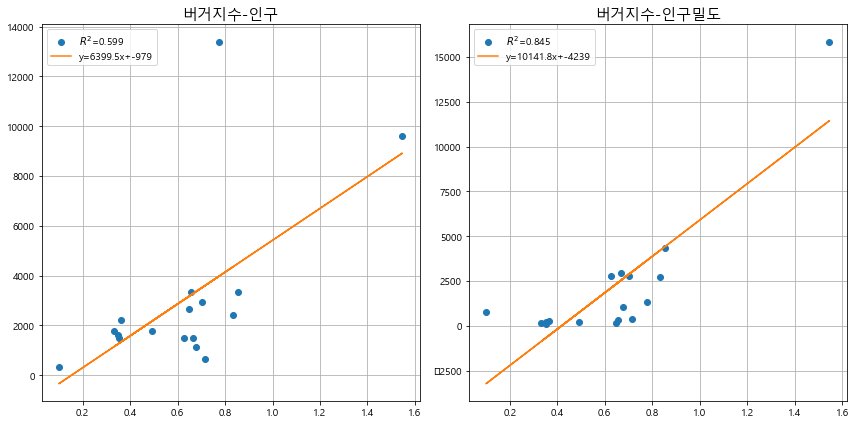

In [70]:
import scipy.stats
x = nstore_pop_df["버거지수"]
col_label = ["인구", "인구밀도"]

fig, axes = plt.subplots(1,2, figsize=(12,6))

for i in range(2):
    ax = axes[i]
    y_label = col_label[i]
#     y = np.array(nstore_pop_df[y_label].tolist())
    y = nstore_pop_df[y_label]
    
    z = np.polyfit(x,y,1)
    f = np.poly1d(z)
    
    R = np.corrcoef(x,y)[0,1]
#     r = scipy.stats.pearsonr(x,y)[0]
    
    ax.plot(x, y,'o', label=r'$R^{2}$'+'={:.3f}'.format(R))
    ax.plot(x, f(x), label='y={:.1f}x+{:.0f}'.format(z[0],z[1]))
    ax.set_title("버거지수-"+y_label, fontsize=15)
    ax.grid(True)
    ax.legend(loc=2)
    
plt.tight_layout()

In [71]:
px.scatter(nstore_pop_df, x='버거지수', y='인구', trendline='ols', hover_name='행정구역')


In [72]:
px.scatter(nstore_pop_df, x='버거지수', y='인구밀도', trendline='ols', hover_name='행정구역')


In [73]:
# 데이터프레임 csv, xlsx 파일로 내보내기
nstore_pop_df.drop("행정구역", axis=1, inplace=True)
nstore_pop_df

,버거킹,KFC,맥도날드,롯데리아,버거지수,BKM,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비,인구,인구밀도
0,9,3,7,54,0.351852,19,강원도,32061,29392,18997,16811,1515,90
1,100,50,96,317,0.776025,246,경기도,36133,38466,20482,17399,13405,1315
2,24,4,29,87,0.655172,57,경상남도,33690,32140,18939,16426,3350,318
3,25,4,15,68,0.647059,44,경상북도,40272,34873,18611,16217,2655,140
4,15,3,10,42,0.666667,28,광주광역시,27548,30964,20532,18231,1488,2969
5,20,10,25,66,0.833333,55,대구광역시,23744,27798,19210,17850,2419,2738
6,14,5,13,51,0.627451,32,대전광역시,28364,31548,20498,18025,1500,2780
7,20,9,41,82,0.853659,70,부산광역시,27409,29388,19680,18030,3344,4342
8,111,73,96,181,1.546961,280,서울특별시,44865,49121,23440,21891,9602,15865
9,0,1,0,10,0.100000,1,세종특별자치시,35826,36983,19789,16762,349,750


In [74]:
nstore_pop_df.to_csv("burger_stat_df.csv", index=False)
nstore_pop_df.to_excel("burger_stat_df.xlsx", index=False)

os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 'burger_df.csv',
 'burger_map_seoul.html',
 'burger_stat_df.csv',
 'burger_stat_df.xlsx',
 'burger_visualization_donghwa.ipynb',
 'burger_visualization_donghwa_folium.ipynb',
 'seoul_muncipalities_geo.json',
 'stat_100701.xls',
 '도시지역_인구현황_시군구__20210703233117.csv',
 '서울시 행정구역 시군구 정보 (좌표계_ WGS1984).csv',
 '시도별_1인당_지역내총생산__지역총소득__개인소득_20210702225439.csv']

추가로 더 해볼 것
## 시군구별 인구수
- 출처 : 시군구별 인구수 [통계청](https://kosis.kr/statHtml/statHtml.do?orgId=315&tblId=TX_315_2009_H1001&conn_path=I2)

# PART IV. 브랜드 사이의 상관관계
KFC가 많은 곳에 버거킹도 많지 않을까? 버거킹이 적은 곳엔 롯데리아가 많지 않을까? 하는 물음에 답을 해줄 수 있을 것이다.

In [75]:
nstore_df

,버거킹,KFC,맥도날드,롯데리아,BKM,버거지수,주소,주소1,주소2
0,1,0,1,6,2,0.333333,강원도 강릉시,강원도,강릉시
1,1,0,1,3,2,0.666667,강원도 속초시,강원도,속초시
2,3,1,2,15,6,0.400000,강원도 원주시,강원도,원주시
3,2,2,2,7,6,0.857143,강원도 춘천시,강원도,춘천시
4,2,0,0,2,2,1.000000,강원도 홍천군,강원도,홍천군
...,...,...,...,...,...,...,...,...,...
235,0,0,0,1,0,0.000000,충청북도 보은군,충청북도,보은군
236,0,0,0,1,0,0.000000,충청북도 영동군,충청북도,영동군
237,0,0,0,2,0,0.000000,충청북도 옥천군,충청북도,옥천군
238,0,0,0,1,0,0.000000,충청북도 증평군,충청북도,증평군


In [76]:
brand_df = nstore_df.set_index(nstore_df["주소"])[["버거킹","KFC","맥도날드","롯데리아"]]
brand_df

,버거킹,KFC,맥도날드,롯데리아
주소,,,,
강원도 강릉시,1,0,1,6
강원도 속초시,1,0,1,3
강원도 원주시,3,1,2,15
강원도 춘천시,2,2,2,7
강원도 홍천군,2,0,0,2
...,...,...,...,...
충청북도 보은군,0,0,0,1
충청북도 영동군,0,0,0,1
충청북도 옥천군,0,0,0,2


In [77]:
brand_df.describe()

,버거킹,KFC,맥도날드,롯데리아
count,240.000000,240.000000,240.000000,240.000000
mean,1.708333,0.779167,1.687500,5.433333
std,2.277398,1.383247,2.275541,5.529280
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000,4.000000
75%,3.000000,1.000000,3.000000,8.000000
max,12.000000,9.000000,12.000000,30.000000


In [82]:
# 한글 패치
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np

plt.rc('font', family='Darwin')
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

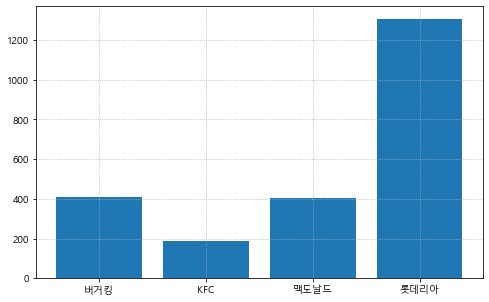

In [83]:
fig = plt.figure(figsize=(8,5))
plt.bar(brand_df.sum().index, brand_df.sum())
plt.grid(True, linestyle=':')

In [84]:
# 수치로 확인
brand_df.corr()

,버거킹,KFC,맥도날드,롯데리아
버거킹,1.000000,0.740527,0.831703,0.786932
KFC,0.740527,1.000000,0.743651,0.566187
맥도날드,0.831703,0.743651,1.000000,0.749720
롯데리아,0.786932,0.566187,0.749720,1.000000


In [85]:
BMK = brand_df.to_numpy().T
BMK.shape # index - 0:버거킹, 1:KFC, 2:맥도날드, 3:롯데리아

(4, 240)

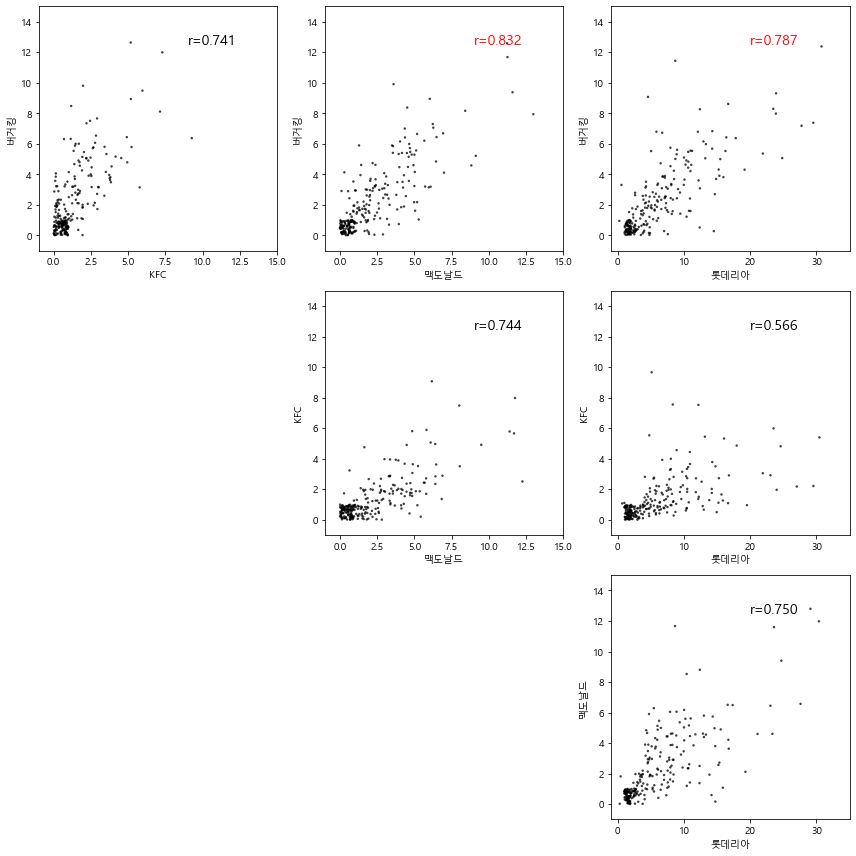

In [86]:
#매장별 상관관계 분석하기
import scipy.stats
import numpy as np

fig = plt.figure(figsize=(12,12))

def plot_nstores3(b1, b2, label1, label2):
    plt.scatter(brand_df[b1] + np.random.random(len(brand_df)),
                brand_df[b2] + np.random.random(len(brand_df)),
                edgecolor='none', alpha=0.75, s=6, c='black')
    plt.xlim(-1, 15 if (b1 != '롯데리아') & (b1 != '맘스터치') else 35)
    plt.ylim(-1, 15 if (b2 != '롯데리아') & (b2 != '맘스터치') else 35)
    plt.xlabel(label1)
    plt.ylabel(label2)

    r = scipy.stats.pearsonr(brand_df[b1], brand_df[b2])

    if r[0]>=0.75:
        color='red'
    elif r[0]<0.5:
        color='blue'
    else:
        color='black'

    plt.annotate('r={:.3f}'.format(r[0]), (9 if (b1 != '롯데리아') & (b1 != '맘스터치') else 20,
                                          12.5 if (b2 != '롯데리아') &(b2 != '맘스터치') else 20),
                 fontsize=14, color=color)
bgbrands = [
            ('버거킹', '버거킹'), ('KFC', 'KFC'),('맥도날드', '맥도날드'),('롯데리아','롯데리아')
]

for a in range(len(bgbrands) - 1):
    for b in range(1, len(bgbrands)):
        if a >= b:
            continue
        ax = fig.add_subplot(len(bgbrands)-1, len(bgbrands)-1, a * 3 + b)
        acol, alabel = bgbrands[a]
        bcol, blabel = bgbrands[b]
        plot_nstores3(bcol, acol, blabel, alabel)

plt.tight_layout()
